In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("image", cmap="gray", interpolation="bicubic")
figsize(10, 10)
import scipy.ndimage as ndi
import warnings
warnings.filterwarnings("always")
import ocrodeg

# DATA AUGMENTATION

# Data Augmentation for OCR

- labeled training data is expensive, hard to come by
- we have large amounts of unlabeled training data
- unlabeled training data can be acquired cheaply and at high quality
- degradation and augmentation models are good enough to generalize well to real data

# Training from Synthetic Data

<img src="figs/synthetictraining.png" width=800>

# Training from Clean Real Data

<img src="figs/mixedtraining.png" width=800>

# Flatbed Scanner

Scanner                                    | Output
:-----------------------------------------:|:-------------------------------:
<img src="figs/flatbed-scanner.jpg" width=400>       | <img src="figs/W1P0.png" width=400>

# High Volume Scanner


Scanner                                         | Sample
:----------------------------------------------:|:------------------------------------------:
<img src="figs/document-scanner.jpg" width=400> | <img src="figs/W1P0.png" width=400>

# Book Scanner

Scanner                                      | Sample
:-------------------------------------------:|:---------------------------:
<img src="figs/archive-scanner.jpg" width=400>    | <img src="figs/booksample.png" width=400>

# Phone Scanning

Scanner                    | Sample
:-------------------------:|:-------------------------------:
<img src="figs/abby-finescan.png" width=400> | <img src="figs/abbyscan.jpg" width=400>

# Different Document Capture Techniques

You need to pick the right preprocessing pipeline depending on your data source:


    
| What                       | Flatbed                    | Sheetfed                   | Book                       | Phone                      |
|----------------------------|----------------------------|----------------------------|----------------------------|----------------------------|
| Resolution                 | 300-9600 dpi               | 300-2400 dpi               | 200-400 dpi                | 100-400 dpi |
| Rotation                   | correct by default         | forced by hardware         | correct by default         | variable    |
| Skew                       | very small                 | usually small              | high                       | extreme     |
| Illumination               | very uniform               | uniform                    | variable                   | higly varible |
| Deformations               | very small                 | small                      | high (w/correction)        | very high   |

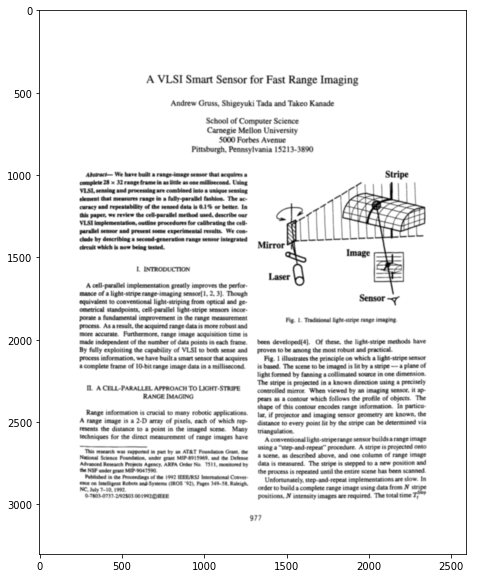

In [3]:
image = imread("testdata/W1P0.png")
imshow(image)

# PAGE ROTATION

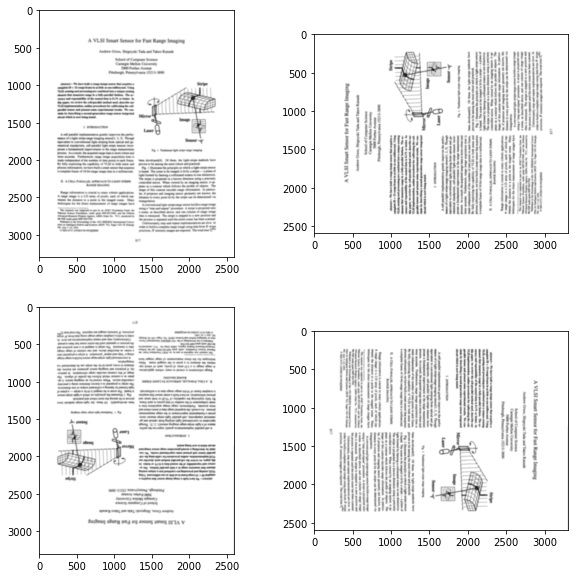

In [4]:
for i, angle in enumerate([0, 90, 180, 270]):
    subplot(2, 2, i+1)
    imshow(ndi.rotate(image, angle))

# RANDOM GEOMETRIC TRANSFORMATIONS

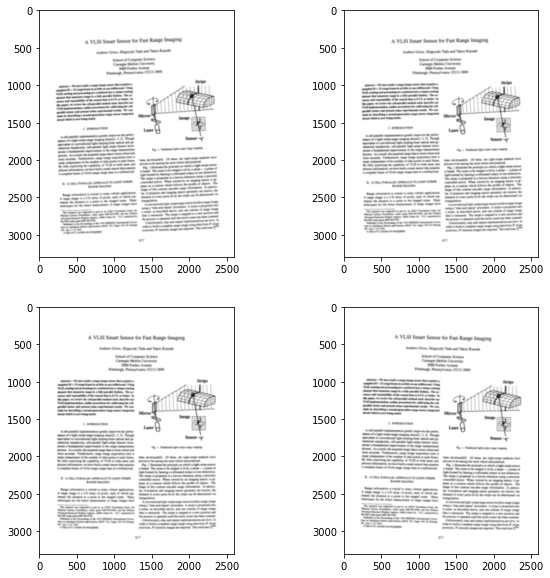

In [5]:
for i, angle in enumerate([-2, -1, 0, 1]):
    subplot(2, 2, i+1)
    imshow(ocrodeg.transform_image(image, angle=angle*pi/180))

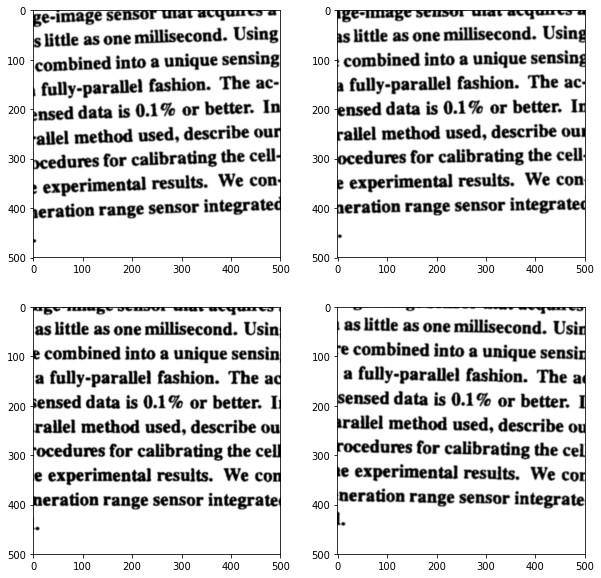

In [6]:
for i, angle in enumerate([-2, -1, 0, 1]):
    subplot(2, 2, i+1)
    imshow(ocrodeg.transform_image(image, angle=angle*pi/180)[1000:1500, 750:1250])

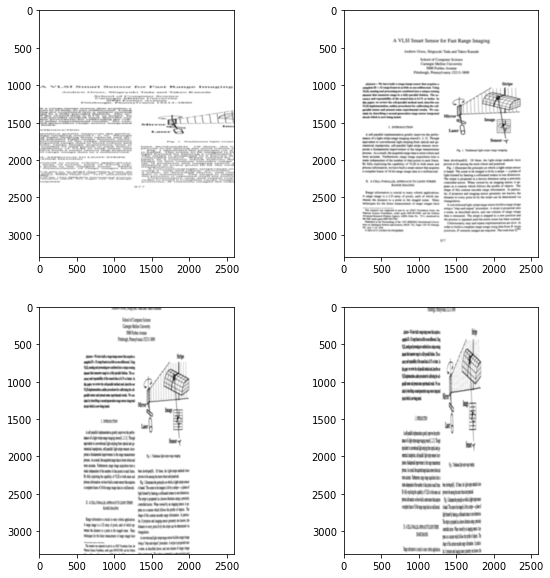

In [7]:
for i, aniso in enumerate([0.5, 1.0, 1.5, 2.0]):
    subplot(2, 2, i+1)
    imshow(ocrodeg.transform_image(image, aniso=aniso))

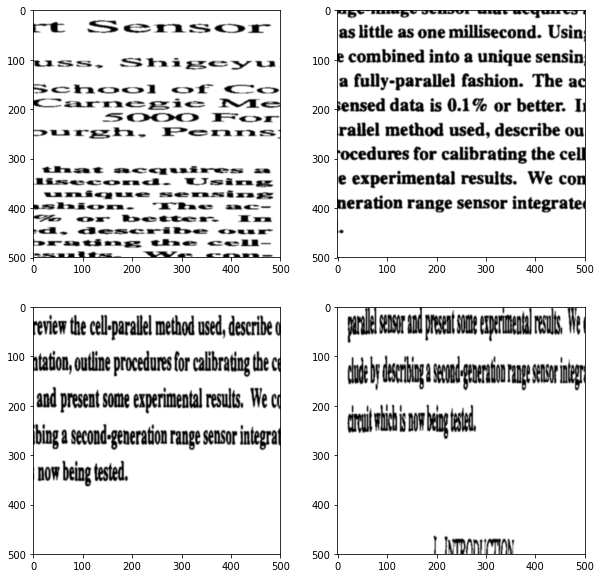

In [8]:
for i, aniso in enumerate([0.5, 1.0, 1.5, 2.0]):
    subplot(2, 2, i+1)
    imshow(ocrodeg.transform_image(image, aniso=aniso)[1000:1500, 750:1250])

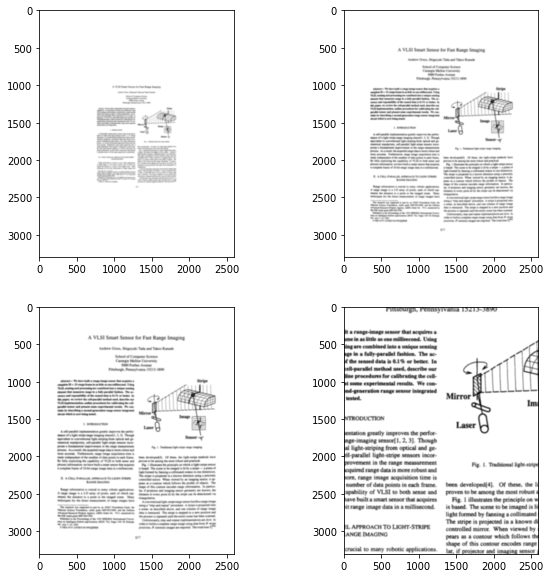

In [9]:
for i, scale in enumerate([0.5, 0.9, 1.0, 2.0]):
    subplot(2, 2, i+1)
    imshow(ocrodeg.transform_image(image, scale=scale))

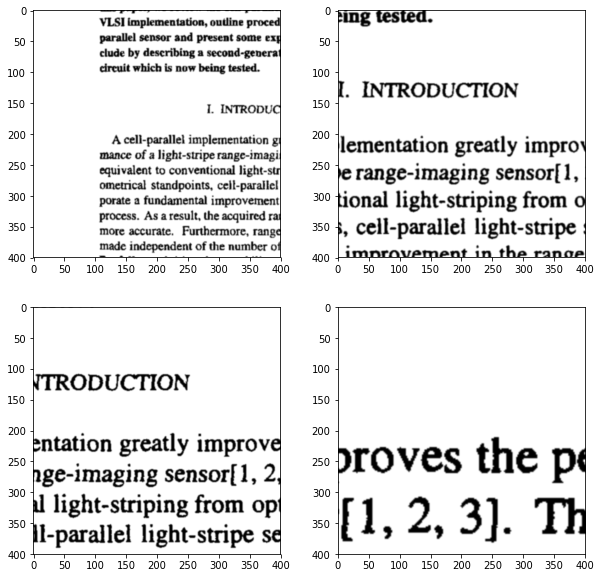

In [10]:
for i, scale in enumerate([0.5, 0.9, 1.0, 2.0]):
    subplot(2, 2, i+1)
    h, w = image.shape
    imshow(ocrodeg.transform_image(image, scale=scale)[h//2-200:h//2+200, w//3-200:w//3+200])

# RANDOM DISTORTIONS

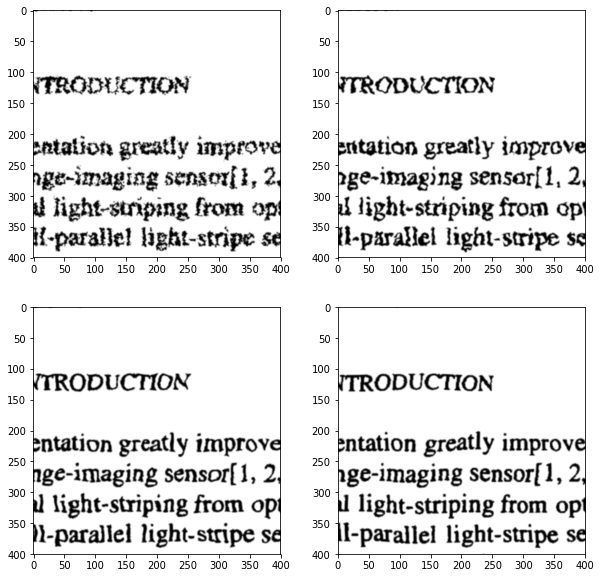

In [11]:
for i, sigma in enumerate([1.0, 2.0, 5.0, 20.0]):
    subplot(2, 2, i+1)
    noise = ocrodeg.bounded_gaussian_noise(image.shape, sigma, 5.0)
    distorted = ocrodeg.distort_with_noise(image, noise)
    h, w = image.shape
    imshow(distorted[h//2-200:h//2+200, w//3-200:w//3+200])

# Random Distortions

- random distortions can be a good model of page warp, damp paper, and other effects
- generated by...
  - generate two arrays of Gaussian noise
  - smooth the noise with a Guassian
  - add the smoothed noise to arrays of the x,y coordinates of the pixels
  - for each pixel, retrieve the source value at the computed coordinates

# RULED SURFACE DISTORTIONS

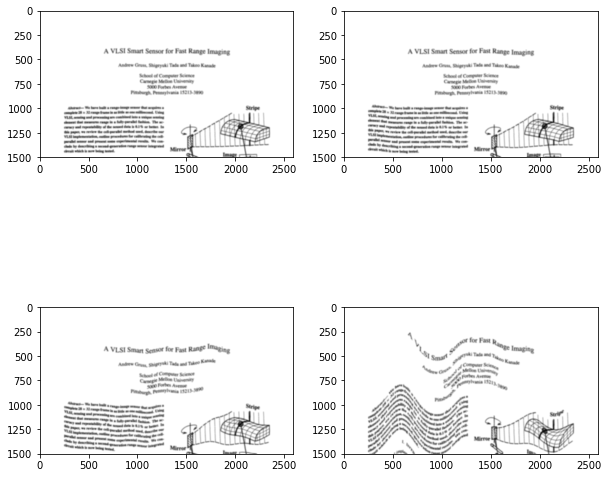

In [12]:
for i, mag in enumerate([5.0, 20.0, 100.0, 200.0]):
    subplot(2, 2, i+1)
    noise = ocrodeg.noise_distort1d(image.shape, magnitude=mag)
    distorted = ocrodeg.distort_with_noise(image, noise)
    h, w = image.shape
    imshow(distorted[:1500])

# Ruled Surfaces

- Paper is generally not very flexible, but it can curve along one direction.
- Such surfaces are called ruled surfaces.
- We can simulate them with the right kind of distortion.
- We can also simulate them by physical modeling and ray tracing.

These kinds of distortions are useful for training camera-based document capture pipelines.


# BLUR, THRESHOLDING, NOISE

# Imaging Pipeline

- document images start out as ideal binary images
- printing and scanning can be viewed as a noisy communications channel
- primary sources of noise:
  - paper and ink texture
  - variability in illumination
  - lens blur, motion blur
  - dirt and damage
  - sensor noise
  - thresholding
  - compression noise
- these can be simulated quite accurately

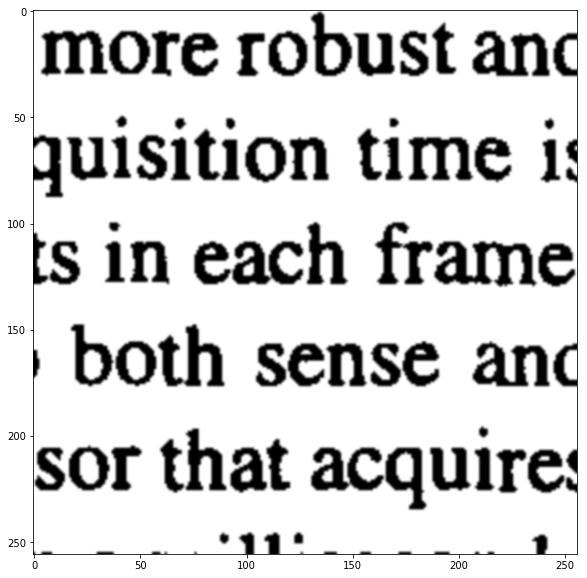

In [13]:
patch = image[1900:2156, 1000:1256]
imshow(patch)

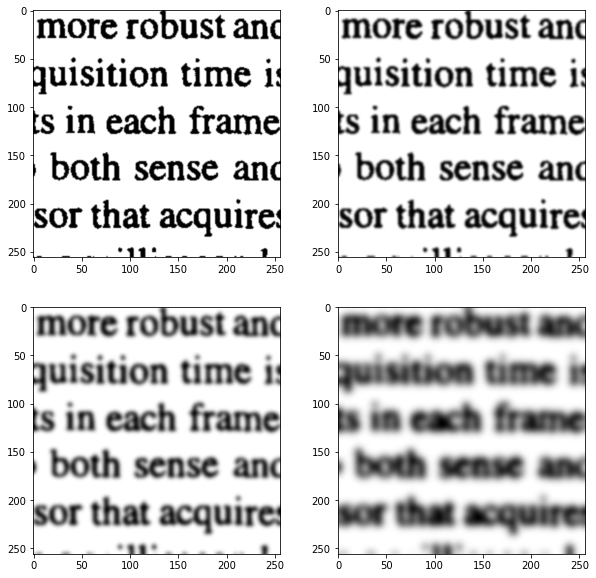

In [14]:
# lens blur
for i, s in enumerate([0, 1, 2, 4]):
    subplot(2, 2, i+1)
    blurred = ndi.gaussian_filter(patch, s)
    imshow(blurred)

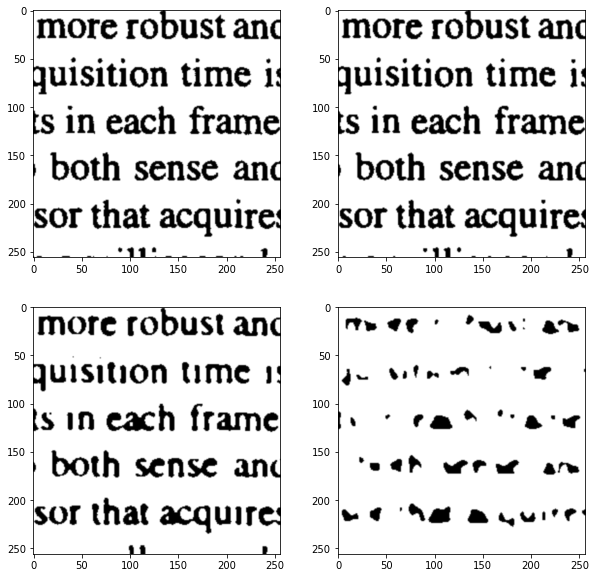

In [15]:
# lens blur with thresholding
for i, s in enumerate([0, 1, 2, 4]):
    subplot(2, 2, i+1)
    blurred = ndi.gaussian_filter(patch, s)
    thresholded = 1.0*(blurred>0.5)
    imshow(thresholded)

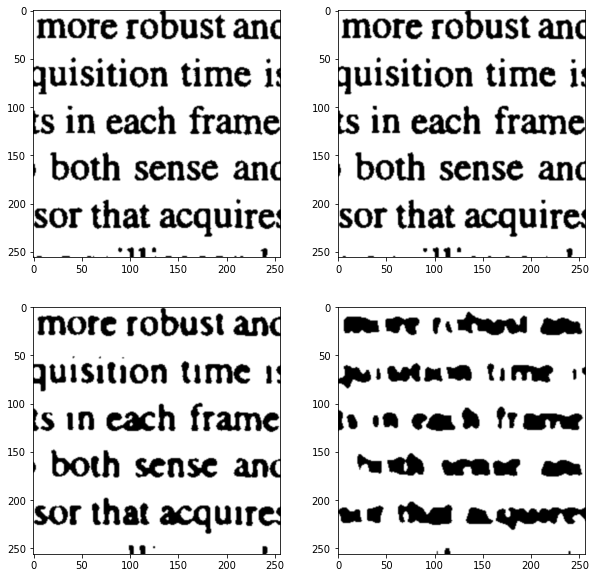

In [16]:
# lens blur with thresholding and constant black pixels
for i, s in enumerate([0.0, 1.0, 2.0, 4.0]):
    subplot(2, 2, i+1)
    blurred = ocrodeg.binary_blur(patch, s)
    imshow(blurred)


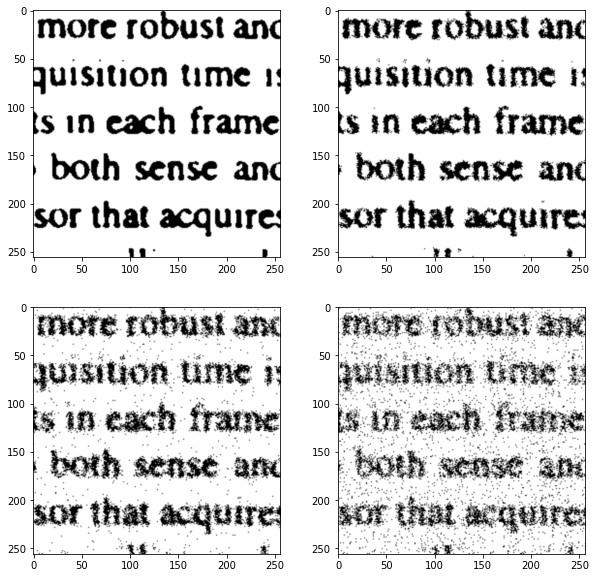

In [17]:
# lens blur with additive noise
for i, s in enumerate([0.0, 0.1, 0.2, 0.3]):
    subplot(2, 2, i+1)
    blurred = ocrodeg.binary_blur(patch, 2.0, noise=s)
    imshow(blurred)

# MULTISCALE NOISE

# Multiscale Noise

Often, noise isn't just Gaussian noise at one scale, but noise at different scales from different sources.

Two options for fast simulations:
- filter Gaussian noise with an FFT
- generate noise at different scales, zoom, and add

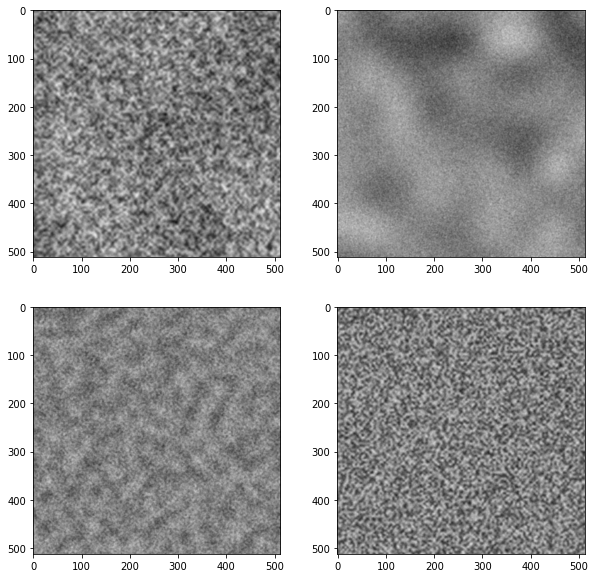

In [18]:
reload(ocrodeg)
for i in range(4):
    noisy = ocrodeg.make_multiscale_noise_uniform((512, 512))
    subplot(2, 2, i+1); imshow(noisy, vmin=0, vmax=1)

# RANDOM BLOBS

# Random Blobs

Many processes generate small random blobs:

- black blobs from dirt or particles stuck to the paper
- light blobs from ink drop-out (literally, peeling off)

We can simulate this quite well.

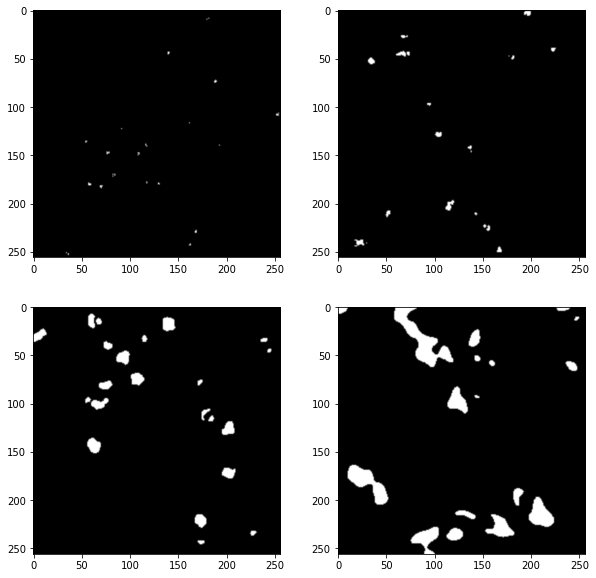

In [19]:
for i, s in enumerate([2, 5, 10, 20]):
    subplot(2, 2, i+1)
    imshow(ocrodeg.random_blobs(patch.shape, 3e-4, s))

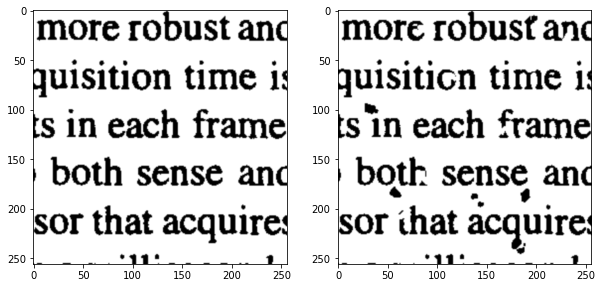

In [20]:
# dirt plus dropout
reload(ocrodeg)
blotched = ocrodeg.random_blotches(patch, 3e-4, 1e-4)
subplot(121); imshow(patch); subplot(122); imshow(blotched)

# FIBROUS NOISE

# Fibrous Noise

- Paper has a clearly visible fibrous structure. 
- Structure shows up during scanning.
- We can imulate this pretty well using a physical simulation (random walk, composition)

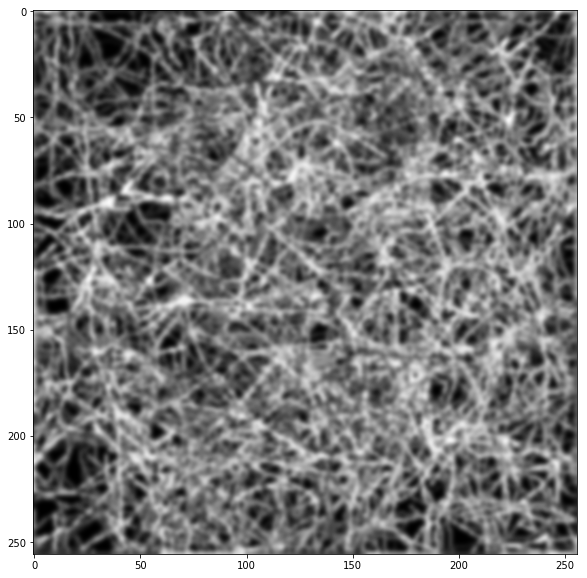

In [21]:
imshow(ocrodeg.make_fibrous_image((256, 256), 700, 300, 0.01))

# FOREGROUND / BACKGROUND SELECTION

# High Quality Image Degradation

Ideally, the original binary image does not generate just a black-and-white image, it selects between a foreground (ink) texture and a background (paper) texture.

We can implement this process directly to get natural looking degraded images.

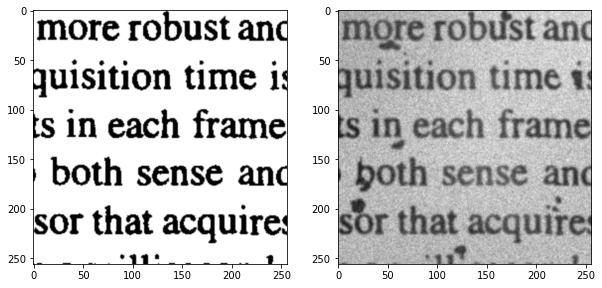

In [22]:
subplot(121); imshow(patch); subplot(122); imshow(ocrodeg.printlike_multiscale(patch))

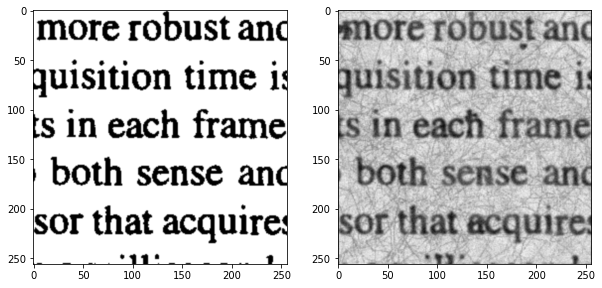

In [23]:
subplot(121); imshow(patch); subplot(122); imshow(ocrodeg.printlike_fibrous(patch))

# GANs for Synthetic Training Data

Can we automate document image degradation?

Can we say "make this document look like that document"?

GANs and MUNIT to the rescue.

These methods automate "does the degraded document look different from a real document?"

Tough call to match the manually constructed pipelines